In [1]:
import pandas as pd
import numpy as np
import wrangle
import matplotlib.pyplot as plt

# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
import sklearn.preprocessing
import warnings
warnings.filterwarnings("ignore")
import wrangle
from sklearn.model_selection import train_test_split


In [2]:
df = wrangle.wrangle_zillow()

In [3]:
df.head(3)

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
3,0.0,0.0,5068.0,1174475.0,1948.0,14557.57,6037.0
4,0.0,0.0,1776.0,440101.0,1947.0,5725.17,6037.0
5,0.0,0.0,2400.0,287634.0,1943.0,3661.28,6037.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2813556 entries, 3 to 2982283
Data columns (total 7 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   bedroomcnt                    float64
 1   bathroomcnt                   float64
 2   calculatedfinishedsquarefeet  float64
 3   taxvaluedollarcnt             float64
 4   yearbuilt                     float64
 5   taxamount                     float64
 6   fips                          object 
dtypes: float64(6), object(1)
memory usage: 171.7+ MB


In [5]:
df.fips = df.fips.astype('int')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2813556 entries, 3 to 2982283
Data columns (total 7 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   bedroomcnt                    float64
 1   bathroomcnt                   float64
 2   calculatedfinishedsquarefeet  float64
 3   taxvaluedollarcnt             float64
 4   yearbuilt                     float64
 5   taxamount                     float64
 6   fips                          int64  
dtypes: float64(6), int64(1)
memory usage: 171.7 MB


In [7]:
train_validate, test = train_test_split(df, random_state=123, train_size=.8)
train, validate = train_test_split(train_validate, random_state=123, train_size=.7)

In [8]:
train.shape

(1575590, 7)

In [9]:
validate.shape

(675254, 7)

In [10]:
test.shape

(562712, 7)

In [11]:
train.head(3)

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
2113106,4.0,2.0,1871.0,624276.0,1977.0,7478.36,6037
766770,4.0,3.0,3444.0,180519.0,1962.0,2341.60,6037
2595160,3.0,2.0,1499.0,256766.0,1965.0,2822.68,6111


In [12]:
y_train = train.taxvaluedollarcnt
x_train = train.drop(columns=['taxvaluedollarcnt'])

y_validate = validate.taxvaluedollarcnt
x_validate = validate.drop(columns=['taxvaluedollarcnt'])

y_test = test.taxvaluedollarcnt
x_test = test.drop(columns=['taxvaluedollarcnt'])

In [13]:
x_train.columns

Index(['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet',
       'yearbuilt', 'taxamount', 'fips'],
      dtype='object')

In [14]:
y_train.head(2)

2113106    624276.0
766770     180519.0
Name: taxvaluedollarcnt, dtype: float64

In [15]:
scaler = sklearn.preprocessing.MinMaxScaler()

In [16]:
scaler.fit(x_train)

MinMaxScaler()

In [17]:
x_train_scaled = scaler.transform(x_train)
x_validate_scaled = scaler.transform(x_validate)
x_test_scaled = scaler.transform(x_test)

Text(0.5, 1.0, 'Scaled')

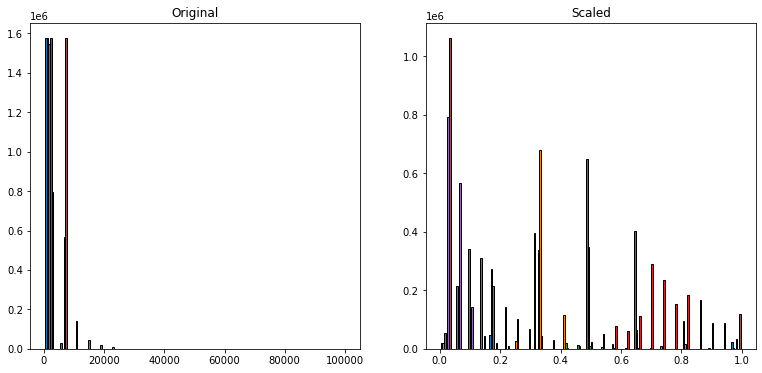

In [18]:
plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.hist(x_train, bins=25, ec='black')
plt.title('Original')
plt.subplot(122)
plt.hist(x_train_scaled, bins=25, ec='black')
plt.title('Scaled')

### Baseline

In [19]:
y_train.mean()

391039.6407250617

In [20]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [21]:
y_train['baseline'] = y_train.taxvaluedollarcnt.mean()
y_validate['baseline'] = y_validate.taxvaluedollarcnt.mean()

In [22]:
y_train.head(1)

,taxvaluedollarcnt,baseline
2113106,624276.0,391039.640725


In [23]:
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.baseline)**(1/2)
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.baseline)**(1/2)

In [24]:
rmse_train

299709.96470061934

In [25]:
rmse_validate

299954.0009944602

### Model 

### Linear Regression (OLS)

In [49]:
lm = LinearRegression(normalize=True)

In [50]:
lm.fit(x_train_scaled, y_train.taxvaluedollarcnt)

LinearRegression(normalize=True)

In [51]:
y_train['amount_pred_lm'] = lm.predict(x_train_scaled)

In [52]:
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.amount_pred_lm)**(1/2)

In [53]:
y_validate['amount_pred_lm'] = lm.predict(x_validate_scaled)

In [54]:
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.amount_pred_lm)**(1/2)

In [55]:
print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  64636.22964028341 
Validation/Out-of-Sample:  64338.64308759447


### Lasso Lars

In [34]:
lars = LassoLars(alpha=1.0)

In [35]:
lars.fit(x_train, y_train.taxvaluedollarcnt)

LassoLars()

In [36]:
y_train['amount_pred_lars'] = lars.predict(x_train)

In [38]:
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.amount_pred_lars)**(1/2)

In [39]:
y_validate['amount_pred_lars'] = lars.predict(x_validate)

In [58]:
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.amount_pred_lars)**(1/2)

In [41]:
print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  64792.31958985171 
Validation/Out-of-Sample:  64498.05212751794


### Tweedie Regressor (GLM)

In [61]:
glm = TweedieRegressor(power=1, alpha=0)

In [62]:
glm.fit(x_train, y_train.taxvaluedollarcnt)

TweedieRegressor(alpha=0, power=1)

In [63]:
y_train['amount_pred_glm'] = glm.predict(x_train)

In [64]:
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.amount_pred_glm)**(1/2)

In [65]:
y_validate['amount_pred_glm'] = glm.predict(x_validate)

In [66]:
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.amount_pred_glm)**(1/2)

In [67]:
print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  299709.96470061934 
Validation/Out-of-Sample:  299954.0328116094


### Polynomial Regression

In [68]:
pf = PolynomialFeatures(degree=2)

In [69]:
x_train_degree2 = pf.fit_transform(x_train)

In [70]:
x_validate_degree2 = pf.transform(x_validate)

In [71]:
lm2 = LinearRegression(normalize = True)

In [72]:
lm2.fit(x_train_degree2, y_train.taxvaluedollarcnt)

LinearRegression(normalize=True)

In [73]:
y_train['amount_pred_lm2'] = lm2.predict(x_train_degree2)

In [74]:
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.amount_pred_lm2)**(1/2)

In [75]:
y_validate['amount_pred_lm2'] = lm2.predict(x_validate_degree2)

In [76]:
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.amount_pred_lm2)

In [77]:
print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  61086.69942023237 
Validation/Out-of-Sample:  3795917515.9188786
